In [3]:
import pandas as pd
import networkx as nx
from tqdm.notebook import tqdm
import numpy as np
import random
import time
import pickle 

In [16]:
def initDF():
    # INIT
    dff = pd.read_csv('imdb_dataset.tsv', sep='\t', header=None, dtype=str)
    edges = dff.to_records(index=False)
    dff[2] = dff[1].str.extract(r'(\(\d{4})', expand=True)#.str.replace("(", "").fillna(0).astype(int) #FIXME fillna is pretty ugly rn
    dff[2] = dff[2].str.replace("(", "", regex=False).fillna(0).astype(int)
    dff = dff.rename(columns={0: "actor", 1: "movie", 2: "year"})
    dff.loc[dff['movie'] == 'Re']
    dff['movie'] = dff['movie'].replace(['Re'],'Re ')
    dff['movie'] = dff['movie'].replace(['Regen'], 'Regen ')
    return dff


In [20]:
def generateIMDBGraph(in_df):
    '''
    Generates bipartite (0 is actor, 1 is movie) graph of which nodes are 
    movies and actors, and an edge is present if an actor participated in a movie
    Arguments: 
        in_df: dataframe of which columns are (index, actor, movie)
    Returns: 
        Tuple: 
            - graph: graph in which nodes are numerical (and not string)
            - original_graph: graph in which the nodes are a string
            - actor_nodes_f: the list of indices representing the nodes that are of type actor
            - movies_nodes_f: the list of indices representing the nodes that are of type movie
            - actors_f: list of actors (strings)
            - movies_f: list of movies (string)
            
    '''
    in_df = pd.read_csv('imdb_dataset.tsv', sep='\t', header=None, dtype=str)
    edges = in_df.to_records(index=False)
    in_df[2] = in_df[1].str.extract(r'(\(\d{4})', expand=True)#.str.replace("(", "").fillna(0).astype(int) #FIXME fillna is pretty ugly rn
    in_df[2] = in_df[2].str.replace("(", "", regex=False).fillna(0).astype(int)
    in_df = in_df.rename(columns={0: "actor", 1: "movie", 2: "year"})
    in_df.loc[in_df['movie'] == 'Re']
    in_df['movie'] = in_df['movie'].replace(['Re'],'Re ')
    in_df['movie'] = in_df['movie'].replace(['Regen'], 'Regen ')
    actors_f = in_df.actor.unique()
    movies_f = in_df.movie.unique()
    movies_dict = in_df.drop(columns='actor').drop_duplicates().set_index('movie').to_dict('index')
    movies_tuples_list = [(k, v) for k, v in movies_dict.items()] #ugly but convenient for what networkx expects
    original_graph = nx.Graph()
    original_graph.add_nodes_from(actors_f, bipartite = 0) #attribute bipartite following documentation recommendations. In this case 0 is actors_f, 1 is movies_f
    print(f"Number of nodes after adding actors_f is {original_graph.number_of_nodes()}")
    original_graph.add_nodes_from(movies_tuples_list, bipartite = 1)
    print(f"Number of nodes after adding movies_f is {original_graph.number_of_nodes()}") 
    original_graph.add_edges_from(edges)
    graph = nx.convert_node_labels_to_integers(original_graph, label_attribute='original_name')
    actor_nodes_f = {n for n, d in graph.nodes(data=True) if d["bipartite"] == 0}
    movies_nodes_f = set(graph) - actor_nodes_f
    return (graph, original_graph, actor_nodes_f, movies_nodes_f, actors_f, movies_f)



## Question 1
G) Considering only the movies up to year x with x in {1930,1940,1950,1960,1970,1980,1990,2000,2010,2020}, write a function which, given x, computes the average number of movies per actor up to year x. 

In [6]:
def avgMoviesPerActorUpToYear(graph, act_nodes, mv_nodes, year):
    '''
    Given 'year' returns the average number of movies in which an actor participated in.
    Arguments: 
        graph: the IMDB graph (numerical version)
        act_nodes: indices of nodes which are of type actor (kept in memory so that doesn't have to be calculated each time)
        mv_nodes: indices of nodes which are of type movie
        year: year up to which calculation is made
    Returns: 
        year: year taken into consideration
        mean1: mean taking into consideration the whole set of actor nodes (even unborn and dead ones)
        mean2: mean taking into consideration only the actors that made at least one movie in the considered period
    '''
    # get movies nodes up to a certain year
    movies_up_to_year = {x for x,y in graph.nodes(data=True) if y['bipartite'] == 1 and y['year'] <= year}
    # 
    nodes_subset = movies_up_to_year.union(act_nodes) 
    # We have two ways of interpreting the question. One is to consider actors even when they've zero movies, the 
    # other is to consider actors only when they have a non zero counter. Regardless, this is considered later
    subgraph = graph.subgraph(nodes_subset)
    assert subgraph.number_of_nodes() == len(nodes_subset)
    
    subgraph_actor_nodes = {n for n, d in subgraph.nodes(data=True) if d["bipartite"] == 0} #in this case it's not necessary because actors are first nodes (in order), but what I said is not a given
    
    degrees = subgraph.degree(nbunch = subgraph_actor_nodes)
    deg_data = pd.DataFrame(degrees)
    #print(deg_data[1])
    sol = (year, deg_data[1].mean(), deg_data[1].replace(0, np.NaN).mean()) #convenient for output later
    #print(f"Mean: {sol[1]}")
    #print(f"Mean removing zeros: {sol[2]}")
    return sol
    
    #print(a)

## Question 2
3) Considering only the movies up to year x with x in {1930,1940,1950,1960,1970,1980,1990,2000,2010,2020} and restricting to the largest connected component of the graph. Approximate the closeness centrality for each node. Who are the top-10 actors?

[Fast Approximation of Centrality (D. Eppstein, J. Wang)](https://www.ics.uci.edu/~eppstein/pubs/EppWan-SODA-01.pdf)
```
*Pseudocode
1. Let k be the number of iterations needed to obtain the desired error bound
2. In iteration i, pick vertex v_i uniformly at random from G and solve the SSSP problem with v_i as a source. 
3. Let (1) be the centrality estimator for vertex u
```
Where  
(1)  $\hat{c}_u = \frac{1}{\sum_{i=1}^k \frac{n*d(v_i, u)}{k(n-1)}}$

In [7]:
def closenessCentralityUpToYear(graph, act_nodes, year, k = None, epsilon = None):
    '''
    Approximates closeness centrality of graph
    Arguments:
        graph: input graph (numerical values of nodes)
        act_nodes: indices of nodes that are of type actor
        year: year up to which the centrality is wanted
        [k]: number of iterations, compulsory if epsilon is not specified
        [epsilon]: error bound for the centrality estimate (Azuma-Hoeffding epsilon)
    Returns:
        distances_df: dataframe containing the distances of the sampled nodes, and the calculated centrality
        epsilon: epsilon of input (can be None)
        k: k of input
    
    '''
    movies_up_to_year = {x for x,y in graph.nodes(data=True) if y['bipartite'] == 1 and y['year'] <= year}
    nodes_subset = movies_up_to_year.union(act_nodes) 
    cc_subgraph = graph.subgraph(nodes_subset)
    largest_cc = max(nx.connected_components(cc_subgraph), key=len) # get largest CC 
    cc_subgraph = graph.subgraph(largest_cc)
    assert cc_subgraph.number_of_nodes() == len(largest_cc)
    
    if epsilon is not None:
        import math
        k = math.ceil(math.log(cc_subgraph.number_of_nodes())/math.pow(epsilon, 2)) #FIXME: this calculation has to be done on the subgraph
        print(f"Corresponding to epsilon={epsilon} k was calculated as k={k}")
    else: 
        if k is None: 
            raise Exception("If no epsilon is specified, it is compulsory to specify k (num samples)")
    
    print(f"Value of k is {k} and largest cc size is {len(largest_cc)}") 

    # 2. sample k nodes 
    starting_nodes = random.sample(list(largest_cc), k)
    sssp_s = list(map(lambda x: nx.single_source_shortest_path_length(cc_subgraph, x), tqdm(starting_nodes))) # call single_source_shourtest_path_length(cc, sample) for each sample in samples
    '''
    #I wanted to do a dictionary but we actually don't really care about who generates a sample 
    sssp_s_dict = {}
    for starting_node in tqdm(starting_nodes): 
        sssp_s_dict[starting_node] = nx.single_source_shortest_path_length(cc_subgraph, starting_node)'''
    
    n = len(largest_cc)
    distances_df = pd.DataFrame(sssp_s).T
    distances_df['centrality'] = distances_df.mean(numeric_only=True, axis=1).apply(lambda x: 1/(x*(n/(n-1))))
    
    
    return (distances_df, epsilon, k)


In [8]:
def topNActorsGivenCentralities(centralities_df, N = 10):
    '''
        Given dataframe with a column "centrality" returns the top 10 actors (needed because centrality is calculated for movies, too)
        Arguments: 
            centralities_df: dataframe that has to have a column named 'centrality'
            N: lenth of the ranking
        Returns:
            central_actors: top N actors given centralities
    '''
    # This method looks at the centralities, and simply excludes movies from the ranking, if present
    sorted_centralities = centralities_df.sort_values('centrality', ascending=False)['centrality']
    print(type(sorted_centralities))

    central_actors = []
    i = 0
    for index, centr in sorted_centralities.items():
        #print(f"Index {index}, centr: {centr}")
        if G.nodes(data=True)[index]['bipartite'] == 0:
            i+=1
            central_actors.append(G.nodes(data=True)[index]['original_name'])
            if i == 10:
                break

    return central_actors

## Question 3
III) Which is the pair of movies that share the largest number of actors?

Main idea to solve this would be to do an intersection of the edges of each of the movies.

Doing the intersections of all sets can become very expensive timewise. 

Given an unordered set of sets $\hat{S} = \{S_1, .., S_N\}$ for any $N\in\mathbb{N}$ s.t. $|S_i| \leq M$ for any $i=1,..,N$ and $M \in\mathbb{N}$; finding the max intersection would cost $\mathcal{O}(N)$, and $\mathcal{O}(\min{\{|U_i|,|U_j|\}})$ (python documentation), reaching $\mathcal{O}(N*M)$. 

In this case I use the following simple observations: 
- For any two given sets $S_i \neq S_j$ (for $i\neq j = 1, .., N$) it is true that $|S_i \cap S_j| \leq \min \{|S_i|, |S_j|\}$
- Let $m$ be the maximum intersection found until a certain iteration. Then if $U_i$ (or $U_j$) is s.t. $|U_i|<m$ (or $|U_j|<m$) then necessarily $|U_i \cap U_j| < m$, i.e. it is not necessary to do the intersection to infer that the cardinality of that intersection would now surpass the current max. Therefore, it's possible to only check the cardinality and skip the calculation of the intersections.

With this heuristic, although the formal complexity would be essentially the same, in practice a lot of the intersections are skipped. 

In [9]:
def moviesWithMaxCommonNumActors(graph, mv_nodes):
    '''
    Calculates the couple of movies with the most common actors
    Arguments: 
        graph: IMDB graph with integer values
        mv_nodes: list of indices of the movies that are of type 'movie'
    Returns: 
        (movies1, movie2): solution of the problem
    Prints: 
        Number of common 'actors' between the two movies
        
    '''
    mv_act = nx.to_dict_of_lists(graph)
    print(mv_act[1])
    current_solution = (None, None)
    current_max = 0
    for movie in tqdm(mv_nodes):
        if len(mv_act[movie]) >= current_max:
            for second_movie in mv_nodes:
                if len(mv_act[second_movie]) >= current_max and movie != second_movie:
                    temp = len(set(mv_act[movie]).intersection(set(mv_act[second_movie])))
                    if current_max < temp:
                        current_solution = (movie, second_movie)
                        current_max = temp
                        
    print(f"Max: {current_max}")
    nodes_dt = G.nodes.data(True)
    
    return (nodes_dt[current_solution[0]]['original_name'], nodes_dt[current_solution[1]]['original_name'])

## Question 4
Build also the actor graph, whose nodes are only actors and two actors are connected if they did a movie together. Answer to the following question:

Which is the pair of actors who collaborated the most among themselves?

In [35]:
def constructGraphAndFindMaxCollaborationGivenActorsGraph(imdb_df_f):
    '''
    Given IMDB dataset creates actor graph (weighted) and calculates the maximum number of collaborations
    Arguments:
        imdb_df_f: pandas dataframe of columns (actor, movie) 
    Returns:
        actor_graph: actor graph constructed
        mass: the maximum number of collaboration found
        sol: tuple of the two actors that collaborated the most
    '''
    actor_graph_dict = imdb_df_f.groupby('movie')['actor'].apply(list).to_dict()
    mass = 0
    sol = (None, None)
    #k = 0
    for movie in tqdm(actor_graph_dict):
        current_actors_list = actor_graph_dict[movie]
        #if k == 100000:
        #    break
        #k+=1
        for i in range(len(current_actors_list)):
            for j in range(i+1, len(current_actors_list)):
                if current_actors_list[i] != current_actors_list[j]: 
                    if not actor_graph.has_edge(current_actors_list[i], current_actors_list[j]):
                        actor_graph.add_edge(current_actors_list[i], current_actors_list[j], weight=1)
                    else:
                        actor_graph[current_actors_list[i]][current_actors_list[j]]['weight'] += 1
                        if actor_graph[current_actors_list[i]][current_actors_list[j]]['weight'] > mass:
                            mass = actor_graph[current_actors_list[i]][current_actors_list[j]]['weight']
                            sol = (current_actors_list[i], current_actors_list[j])
    return (actor_graph, mass, sol)

In [36]:
# even though max is calculated in the creation of the graph, this is how I'd calculate it if the graph was given
def findMaxCollaborationGivenGraph(gr):
    '''
    Finds edge with max weight and returns the two nodes it connects. Also calculate the histogram of the weights. 
    Arguments: 
        gr: actor graph
    Retruns: 
        massimo: the found maximal edge
        sol: tuple representing the two actors with the most collaborations
        hist: a list representing the histogram of the edge weights
    '''
    archi = gr.edges(data=True)
    massimo = 0
    sol = (None, None)
    hist = [0]*500
    i = 0
    sol = (None, None)
    for arco in archi:
        curr_weight = arco[2]['weight']
        #print(curr_weight)
        if massimo < curr_weight:
            massimo =  curr_weight
            sol = (arco[0], arco[1])
            
        hist[curr_weight] += 1
        i+=1
        if i % 1000000 == 0:
            print(f"Iteration: {i}")
    return (massimo, sol, hist)



# Function calls 

  0%|          | 0/745941 [00:00<?, ?it/s]

Iteration: 1000000
Iteration: 2000000
Iteration: 3000000
Iteration: 4000000
Iteration: 5000000
Iteration: 6000000
Iteration: 7000000
Iteration: 8000000
Iteration: 9000000
Iteration: 10000000
Iteration: 11000000
Iteration: 12000000
Iteration: 13000000
Iteration: 14000000
Iteration: 15000000
Test 4


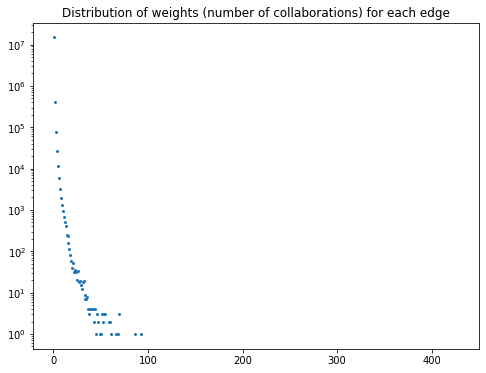

In [40]:
###### MAIN
q4 = True
# Main for questions 1, 2 and 3
if not q4:
    df = initDF()
    G, oriGinal, actor_nodes, movies_nodes, actors_f, movies_f = generateIMDBGraph(df)
    print("Test 0")
    ## Q1
    
    q1_results = []
    for year in tqdm(range(1930, 2021, 10)):
        q1_results.append(avgMoviesPerActorUpToYear(G, actor_nodes, movies_nodes, year))
    q1_df = pd.DataFrame(q1_results).rename(columns={0: "Year", 1: "Average 1", 2: "Average 2"})
    q1_df.plot.bar(x="Year", y=["Average 1", "Average 2"], title="Average number of movies per year", figsize=(10,8))
    
    print("Test 1")
    ## Q2
    data = {}
    for year, epsilon in zip(list(range(1930, 2021, 10)), np.linspace(0.05, 0.3, 10)):
        data[year] = {}
        centralities, eps, kappa = closenessCentralityUpToYear(G, actor_nodes, year, epsilon=epsilon)
        data[year]['epsilon'] = epsilon
        data[year]['year'] = year
        data[year]['centralities'] = centralities
        data[year]['num_samples'] = kappa
        data[year]['top_ten_actors'] = topNActorsGivenCentralities(centralities, N = 10)
        break
    
    data_tuples = []
    cc_sizes = [120720, 180786, 234381, 320719, 451610, 632247, 896126, 1303550, 2380266, 2926072]
    it_s = [2.28, 1.36, 1.01, 1.37, 1.90, 2.60, 3.57, 4.85, 8.09, 9.44]
    i = 0
    for item in data:
        record = (data[item]['year'], data[item]['epsilon'], data[item]['num_samples'], cc_sizes[i], it_s[i])
        i+=1
        data_tuples.append(record)
        print(data[item]['top_ten_actors'])

    data_df = pd.DataFrame(data_tuples).rename(columns={0: "Year", 1: "Epsilon", 2: "Num. Samples", 3: "Largest CC size", 4: "it/s"})
    print("Test 2")
    ## Q3
    result = moviesWithMaxCommonNumActors(G, list(movies_nodes)) #2151046
    print(result)
    print("Test 3")

if q4:
    ### Q4 # better to be run independently
    #df = initDF()
    actors = df.actor.unique()
    actor_graph = nx.Graph()
    actor_graph.add_nodes_from(actors)

    actor_graph, maximum, solution = constructGraphAndFindMaxCollaborationGivenActorsGraph(df)
    maximum, solution, hist = findMaxCollaborationGivenGraph(actor_graph)
    print("Test 4")
    import matplotlib.pyplot as plt
    figure(figsize=(8, 6))

    x = range(0,430)
    y = np.array(hist[0:430])
    plt.title("Distribution of weights (number of collaborations) for each edge")
    plt.scatter(x, y, s=4)
    plt.yscale('log')
    plt.show()


In [38]:
print(maximum)

93
